# 伽马变换
## 应用
许多软件都有伽马变换的应用，诸如美图秀秀、Photoshop此类软件，都在使用

伽马变换的作用是 **「图像对比度调节」**
## 定义
- 伽马变换又叫 **「幂律变换」**，是因为它使用**幂函数**来操作输入图像
- 其数学表达式如下：
    - $ output = (input + \varepsilon) ^ \gamma$
    - ^ 其中 $output$ 是输出灰度值；$\gamma$ 是伽马系数，取正数；$\varepsilon$ 是补偿系数，我们一般设置为 $0$
        - 那么上述的 **「补偿系数」** 到底是干嘛的呢？举个例子来说明：
        - 假设有一个矩阵如下：
        - $\left[ \begin{matrix}0 & 0 & 0 \\ 50 & 50 & 50 \\100 & 100 & 100\end{matrix} \right ]$
        - 我们对其进行 $\gamma$ 变换的时候，就会造成像素值为 $0$ 的区域不变，而其他区域的像素值均变化，所以就会造成“不公平”的现象
        - 为了消除这一“不公平”，那肯定要对 $0$ 值进行补偿，所以当图像中出现大面积的 $0$ 值区域时，如果不加入补偿可能就会造成图像 $\gamma$ 变换效果不理想
        - **原则:** 根据需求来决定 $\varepsilon$ 的取值

## 一些小麻烦
根据上述定义，加入某一像素值为 $100$，$\varepsilon$ 取 $0$，$\gamma$ 取 $3$，则变换后的像素值为：

$$
output = (100 + 0) ^ {3} = 100\times 100 \times 100 = 1000000
$$
这显然超过了我们 $8Bit$ 图像的动态范围
### 问题的解决
由于幂运算可能导致输出图像的动态范围过大，影响图像的输出显示，故我们在此采用 **「归一化」** 手段进行处理，此处的归一化和*深度学习领域*的归一化类似

则采用归一化后的伽马变换公式为：

$$
output = 255 \times \left(\frac{input + \varepsilon}{255}\right) ^ \gamma
$$

通过除以**原图像动态范围**的手段，我们将原始图像进行线性映射到 $[0, 1]$ 区间内，这一过程被称作 **「归一化」** ，然后再将变换完成的 $[0, 1]$ 内取值的结果乘以**原图像动态范围**，将结果**恢复**为原始图像的动态范围（逆归一化）

在此我们使用的图像均为 $[0, 255]$ 的 $8Bit$ 图像，故公式中定义动态范围值为 $255$

下面直接开始实验：

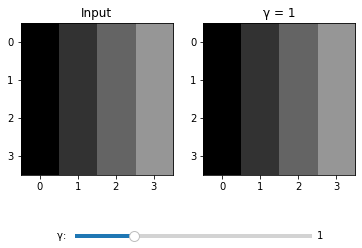

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

# 核心伽马变换函数
def gamma_trans(input, gamma = 2, eps = 0):
    return 255. * (((input + eps) / 255.) ** gamma)


def update_gamma(val):
    gamma = slider1.val
    output = gamma_trans(inp_arr, gamma = gamma)
    ax1.set_title('γ = ' + str(gamma))
    ax1.imshow(output, cmap = 'gray', vmin = 0, vmax = 255)

if __name__ == '__main__':
    inp_arr = np.array([
        [0, 50, 100, 150],
        [0, 50, 100, 150],
        [0, 50, 100, 150],
        [0, 50, 100, 150]
    ])
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    ax0.set_title('Input')
    ax0.imshow(inp_arr, cmap = 'gray', vmin=0, vmax=255)

    ax1 = fig.add_subplot(122)

    plt.subplots_adjust(bottom=0.3)
    s1 = plt.axes([0.25, 0.1, 0.55, 0.03], facecolor = 'lightgoldenrodyellow')
    slider1 = Slider(s1, 'γ: ', 0.0, 4., valfmt='%.f', valinit=1., valstep=0.05)
    slider1.on_changed(update_gamma)
    slider1.reset()
    slider1.set_val(1)
    plt.show()


## 伽马变换的应用
### 用于校正显示失真
日常生活中使用的“大头电视机”，其学名为「CRT显示器」，由于自身的特殊物理性质，这类显示器都会有失真现象的发生，其输出为非线性，在此我们约定：

某一CRT显示器的输出函数为 $output = input^\gamma$，此处的 $\gamma$ 值介于 $[1.8, 2.5]$

为了校正这一类输出显示，很显然，我们只需要对其原始输入图像进行伽马变换，此处取变换伽马值为 $\frac{1}{\gamma}$

实验部分：

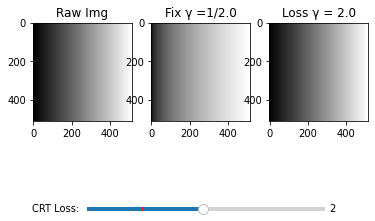

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib as mlp

# 核心伽马变换函数


def gamma_trans(input, gamma=2, eps=0):
    return 255. * (((input + eps) / 255.) ** gamma)


def update_gamma(val):
    gamma = slider1.val

    # 送入 CRT 之前，先进行伽马变换预处理，消除失真
    gamma_ = 1 / gamma
    corrent_img = gamma_trans(inp_arr, gamma_)
    ax1.set_title('Fix γ =1/%.1f' % gamma)
    ax1.imshow(corrent_img, cmap='gray', vmin=0, vmax=255)

    # 矫正过后的图送入 CRT 显示
    output = crt_distortion(corrent_img, gamma=gamma)
    ax2.set_title('Loss γ = %.1f' % gamma)
    ax2.imshow(output, cmap='gray', vmin=0, vmax=255)

# CRT失真模拟函数


def crt_distortion(input, gamma=2):
    return 255. * ((input / 255.) ** gamma)


if __name__ == '__main__':
    inp_arr = np.asarray(Image.open('./伽马变换/intensity_ramp.tif').convert('L'))
    fig = plt.figure()
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    ax0.set_title('Raw Img')
    ax0.imshow(inp_arr, cmap='gray', vmin=0, vmax=255)

    plt.subplots_adjust(bottom=0.3)
    s1 = plt.axes([0.25, 0.1, 0.55, 0.03], facecolor='lightgoldenrodyellow')
    slider1 = Slider(s1, 'CRT Loss: ', 0.1, 4., valfmt='%.f',
                     valinit=1., valstep=0.1)
    slider1.on_changed(update_gamma)
    slider1.reset()
    slider1.set_val(2)
    plt.show()


通过上面的动图可以看到，经过校正后的图像与原始图像一模一样，无论怎么调节 $\gamma$ 值，结果都和输入图片是一样的，这说明校正起到了作用

### 调节图像对比度
我们可以通过上述一系列实验，得到如下结论：
- 伽马变换具有改善图像偏暗或者偏亮的能力
- 这一能力体现在人眼上，会使得图像的细节更加突出，使人眼观察到更多的细节
- 故伽马变换可以调节图像对比度

那么，伽马变换为什么能够起到调整图像对比度的作用呢？
#### 对比度调节原理
**本质原因：**

伽马变换能够对于不同灰度区间的动态范围，做出相对独立的调整

绘制出幂函数的函数图像可能有助于我们理解：
//等待补充图像

我们就拿其中的 $\gamma = 0.25$ 的曲线来进行说明：
- 观察到其函数图像，斜率为由大到小，整个曲线呈现从陡峭到放平缓的趋势
- 这样的图像曲线非常有利于增强对比度
    - 假设原始图像归一化后的某一区间为 $[0, 0.1]$，那么读取图像，可以发现其值被映射到了大约 $[0, 0.55]$ 这个范围，而其真实灰度像素动态范围的变化为 $(0.55 - 0.1)\times 255 = 114.75$，这一范围是相当大的
    - 而上述这一过程直接导致了「暗部变亮」这一特性，是的更多的细节呈现出来，容易被人眼辨认

将上面的过程进行推广，我们显然可以得到以下结论：
- 当 $\gamma = 1$ 时，图像恒等变换，输入输出完全相等（$\varepsilon = 0$）
- 当 $\gamma < 1$ 时，图像的亮度被提高，拓展暗部动态范围，压缩亮部动态范围
- 当 $\gamma > 1$ 时，图像的亮度被降低，拓展亮部动态范围，压缩暗部动态范围

## 对比度增强实战
### Stage 1
我们要对一张人类脊柱的医学图像进行处理，直接上代码：

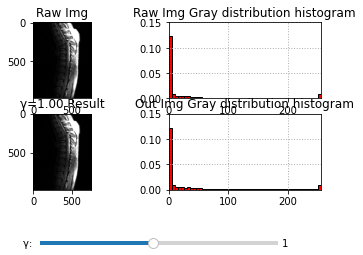

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib as mlp

# mlp.use('TkAgg')


# 核心伽马变换函数
def gamma_trans(input, gamma=2., eps=0):
    return 255. * (((input + eps) / 255.) ** gamma)


def update_gamma(val):
    gamma = slider1.val

    output = gamma_trans(inp_arr, gamma, 0.2)

    ax3.clear()
    ax3.set_title('γ=%.2f Result' % gamma)
    ax3.imshow(output, cmap='gray', vmin=0, vmax=255)

    ax4.clear()
    ax4.grid(True, linestyle=':', linewidth=1)
    ax4.set_title('Out Img Gray distribution histogram')
    ax4.set_xlim(0, 255)
    ax4.set_ylim(0, 0.15)
    ax4.hist(output.flatten(), bins=50, density=True, color='r', edgecolor='k')


if __name__ == '__main__':
    inp_arr = np.asarray(Image.open('./伽马变换/fractured_spine.tif').convert('L'))
    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    ax1.set_title('Raw Img')
    ax1.imshow(inp_arr, cmap='gray', vmin=0, vmax=255)

    # ax2 显示原图的灰度分布直方图
    ax2.grid(True, linestyle=':', linewidth=1)
    ax2.set_title('Raw Img Gray distribution histogram')
    ax2.set_xlim(0, 255)
    ax2.set_ylim(0, 0.15)
    ax2.hist(inp_arr.flatten(), bins=50,
             density=True, color='r', edgecolor='k')

    plt.subplots_adjust(bottom=0.3)
    s1 = plt.axes([0.25, 0.1, 0.55, 0.03], facecolor='lightgoldenrodyellow')
    slider1 = Slider(s1, 'γ: ', 0.1, 2., valfmt='%.f',
                     valinit=1., valstep=0.1)
    slider1.on_changed(update_gamma)
    slider1.reset()
    slider1.set_val(1.)
    plt.show()


可以看到，对比度增强效果非常明显，而根据灰度分布直方图，我们可以清晰地看到：

原始图像的灰度分布较为密集，而经过伽马变换后的灰度分布变稀疏了

### Stage 2
航拍图像，增强：

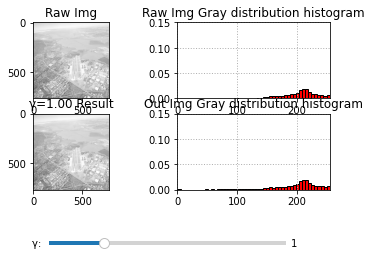

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib as mlp

# mlp.use('TkAgg')


# 核心伽马变换函数
def gamma_trans(input, gamma=2., eps=0):
    return 255. * (((input + eps) / 255.) ** gamma)


def update_gamma(val):
    gamma = slider1.val

    output = gamma_trans(inp_arr, gamma, 0.2)

    ax3.clear()
    ax3.set_title('γ=%.2f Result' % gamma)
    ax3.imshow(output, cmap='gray', vmin=0, vmax=255)

    ax4.clear()
    ax4.grid(True, linestyle=':', linewidth=1)
    ax4.set_title('Out Img Gray distribution histogram')
    ax4.set_xlim(0, 255)
    ax4.set_ylim(0, 0.15)
    ax4.hist(output.flatten(), bins=50, density=True, color='r', edgecolor='k')


if __name__ == '__main__':
    inp_arr = np.asarray(Image.open('./伽马变换/washed_out.tif').convert('L'))
    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    ax1.set_title('Raw Img')
    ax1.imshow(inp_arr, cmap='gray', vmin=0, vmax=255)

    # ax2 显示原图的灰度分布直方图
    ax2.grid(True, linestyle=':', linewidth=1)
    ax2.set_title('Raw Img Gray distribution histogram')
    ax2.set_xlim(0, 255)
    ax2.set_ylim(0, 0.15)
    ax2.hist(inp_arr.flatten(), bins=50,
             density=True, color='r', edgecolor='k')

    plt.subplots_adjust(bottom=0.3)
    s1 = plt.axes([0.25, 0.1, 0.55, 0.03], facecolor='lightgoldenrodyellow')
    slider1 = Slider(s1, 'γ: ', 0.1, 4., valfmt='%.f',
                     valinit=1., valstep=0.1)
    slider1.on_changed(update_gamma)
    slider1.reset()
    slider1.set_val(1.)
    plt.show()
